In [1]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

^C
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/TahaAnwar/pafy.git to c:\users\rohith\appdata\local\temp\pip-install-q_8gbgy3\pafy_54289ffcd4984a9aae3a72ecb5720c84
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb


  Running command git clone -q https://github.com/TahaAnwar/pafy.git 'C:\Users\Rohith\AppData\Local\Temp\pip-install-q_8gbgy3\pafy_54289ffcd4984a9aae3a72ecb5720c84'
    ERROR: Command errored out with exit status 1:
     command: 'C:\Program Files\Python310\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Rohith\\AppData\\Local\\Temp\\pip-install-q_8gbgy3\\pafy_54289ffcd4984a9aae3a72ecb5720c84\\setup.py'"'"'; __file__='"'"'C:\\Users\\Rohith\\AppData\\Local\\Temp\\pip-install-q_8gbgy3\\pafy_54289ffcd4984a9aae3a72ecb5720c84\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\Rohith\AppData\Local\Temp\pip-pip-egg-info-y0zket2x'
         cwd: C:\Users\Rohith\AppData\Local\Temp\pip-install-q_8gbgy3\pafy_5

In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "dataset/UCF50"

CLASSES_LIST =activities = ['BaseballPitch', 'Basketball', 'BenchPress', 'Billiards', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing', 'GolfSwing', 'HorseRace', 'HulaHoop', 'JumpingJack', 'JumpRope', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PlayingGuitar', 'PlayingTabla', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'SoccerJuggling', 'Swing', 'TaiChi', 'VolleyballSpiking']



# Print the folder array
print(CLASSES_LIST)


['BaseballPitch', 'Basketball', 'BenchPress', 'Billiards', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing', 'GolfSwing', 'HorseRace', 'HulaHoop', 'JumpingJack', 'JumpRope', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PlayingGuitar', 'PlayingTabla', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'SoccerJuggling', 'Swing', 'TaiChi', 'VolleyballSpiking']


In [4]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [5]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [6]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: BaseballPitch
Extracting Data of Class: Basketball
Extracting Data of Class: BenchPress
Extracting Data of Class: Billiards
Extracting Data of Class: BreastStroke
Extracting Data of Class: CleanAndJerk
Extracting Data of Class: Diving
Extracting Data of Class: Drumming
Extracting Data of Class: Fencing
Extracting Data of Class: GolfSwing
Extracting Data of Class: HorseRace
Extracting Data of Class: HulaHoop
Extracting Data of Class: JumpingJack
Extracting Data of Class: JumpRope
Extracting Data of Class: MilitaryParade
Extracting Data of Class: Mixing
Extracting Data of Class: Nunchucks
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PlayingTabla
Extracting Data of Class: PommelHorse
Extracting Data of Class: PullUps
Extracting Data of Class: Punch
Extracting Data of Class: PushUps
Extracting Data of Class: Rowing
Extracting Data of Class: SalsaSpin
Extracting Data of Class: SkateBoarding
Extracting Data of Class: Skiing
Extracting Data of Cl

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming you have your features and labels defined somewhere above
# features and labels should be defined before this point

# Assuming labels are in a variable called 'labels'
# One-hot encode the labels
one_hot_encoder = OneHotEncoder()
one_hot_encoded_labels = one_hot_encoder.fit_transform(labels.reshape(-1, 1)).toarray()

# Now you can proceed with the train-test split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size=0.25, shuffle=True)


In [8]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [9]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31)             │        89,311 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,311 (477.78 KB)

 Trainable params: 122,311 (477.78 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [10]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])


In [11]:
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 243s 345ms/step - accuracy: 0.1372 - loss: 3.0981 - val_accuracy: 0.3579 - val_loss: 2.2111
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 175s 281ms/step - accuracy: 0.4085 - loss: 2.0227 - val_accuracy: 0.4414 - val_loss: 1.8996
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 182s 292ms/step - accuracy: 0.5844 - loss: 1.4109 - val_accuracy: 0.5907 - val_loss: 1.5024
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 177s 284ms/step - accuracy: 0.7098 - loss: 0.9835 - val_accuracy: 0.6276 - val_loss: 1.3711
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 182s 292ms/step - accuracy: 0.7840 - loss: 0.7204 - val_accuracy: 0.6629 - val_loss: 1.2301
Epoch 6/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 182s 291ms/step - accuracy: 0.8467 - loss: 0.4929 - val_accuracy: 0.6693 - val_loss: 1.2990
Epoch 7/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 181s 291ms/step - accuracy: 0.8765 - loss: 0.3945 - val_accuracy: 0.6629 - val_loss: 1.3114
Epoch 8/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 177s 284ms/step - accuracy: 0.9059 -

In [12]:
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 199s 319ms/step - accuracy: 0.8424 - loss: 0.4980 - val_accuracy: 0.6613 - val_loss: 1.2671
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 187s 300ms/step - accuracy: 0.8859 - loss: 0.3778 - val_accuracy: 0.6982 - val_loss: 1.2453
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 192s 308ms/step - accuracy: 0.9231 - loss: 0.2640 - val_accuracy: 0.6726 - val_loss: 1.4432
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 186s 299ms/step - accuracy: 0.9290 - loss: 0.2239 - val_accuracy: 0.6324 - val_loss: 1.6817
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 188s 301ms/step - accuracy: 0.9191 - loss: 0.2450 - val_accuracy: 0.6886 - val_loss: 1.4506
Epoch 6/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 182s 292ms/step - accuracy: 0.9418 - loss: 0.1735 - val_accuracy: 0.6822 - val_loss: 1.5208
Epoch 7/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 186s 299ms/step - accuracy: 0.9542 - loss: 0.1433 - val_accuracy: 0.7175 - val_loss: 1.5339
Epoch 8/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 184s 295ms/step - accuracy: 0.9544 -

In [13]:
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 198s 317ms/step - accuracy: 0.8465 - loss: 0.4751 - val_accuracy: 0.6934 - val_loss: 1.2440
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 184s 295ms/step - accuracy: 0.9001 - loss: 0.3131 - val_accuracy: 0.6677 - val_loss: 1.3879
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 185s 296ms/step - accuracy: 0.9254 - loss: 0.2501 - val_accuracy: 0.7014 - val_loss: 1.3227
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 185s 296ms/step - accuracy: 0.9403 - loss: 0.1961 - val_accuracy: 0.7239 - val_loss: 1.3922
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 185s 296ms/step - accuracy: 0.9274 - loss: 0.2171 - val_accuracy: 0.7143 - val_loss: 1.3522
Epoch 6/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 181s 291ms/step - accuracy: 0.9539 - loss: 0.1424 - val_accuracy: 0.7079 - val_loss: 1.5123
Epoch 7/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 179s 288ms/step - accuracy: 0.9453 - loss: 0.1648 - val_accuracy: 0.7303 - val_loss: 1.4709
Epoch 8/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 178s 286ms/step - accuracy: 0.9616 -

In [14]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.7305 - loss: 1.1011


In [16]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()
# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = 'convlstm_model1.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [17]:
# Load the model from the H5 file
convlstm_model = tf.keras.models.load_model('convlstm_model.h5')

# Make predictions on the test data
predictions = convlstm_model.predict(features_test)

# Convert one-hot encoded predictions back to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels back to class labels
true_labels = np.argmax(labels_test, axis=1)

# Initialize dictionaries to store counts of correct and wrong predictions for each label
correct_predictions_count = {}
wrong_predictions_count = {}

# Loop through each label
for label_index, class_name in enumerate(CLASSES_LIST):
    # Find indices where the true label matches the current label
    indices = np.where(true_labels == label_index)[0]
    
    # Count how many predictions for those indices are correct
    correct_count = np.sum(predicted_labels[indices] == true_labels[indices])
    
    # Count how many predictions for those indices are wrong
    wrong_count = len(indices) - correct_count
    
    # Store counts in the dictionaries
    correct_predictions_count[class_name] = correct_count
    wrong_predictions_count[class_name] = wrong_count

# Print the counts of correct and wrong predictions for each label
for class_name in CLASSES_LIST:
    print(f'Label: {class_name}, Correct Predictions: {correct_predictions_count[class_name]}, Wrong Predictions: {wrong_predictions_count[class_name]}')


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 491ms/step
Label: BaseballPitch, Correct Predictions: 39, Wrong Predictions: 5
Label: Basketball, Correct Predictions: 20, Wrong Predictions: 13
Label: BenchPress, Correct Predictions: 47, Wrong Predictions: 4
Label: Billiards, Correct Predictions: 36, Wrong Predictions: 0
Label: BreastStroke, Correct Predictions: 28, Wrong Predictions: 3
Label: CleanAndJerk, Correct Predictions: 16, Wrong Predictions: 14
Label: Diving, Correct Predictions: 32, Wrong Predictions: 7
Label: Drumming, Correct Predictions: 31, Wrong Predictions: 4
Label: Fencing, Correct Predictions: 20, Wrong Predictions: 3
Label: GolfSwing, Correct Predictions: 20, Wrong Predictions: 9
Label: HorseRace, Correct Predictions: 22, Wrong Predictions: 10
Label: HulaHoop, Correct Predictions: 17, Wrong Predictions: 17
Label: JumpingJack, Correct Predictions: 29, Wrong Predictions: 9
Label: JumpRope, Correct Predictions: 30, Wrong Predictions: 9
Label: MilitaryParade, Correct Predictions: 17, Wron

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

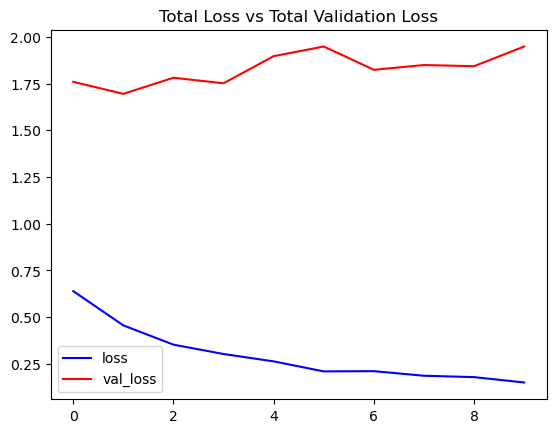

In [24]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

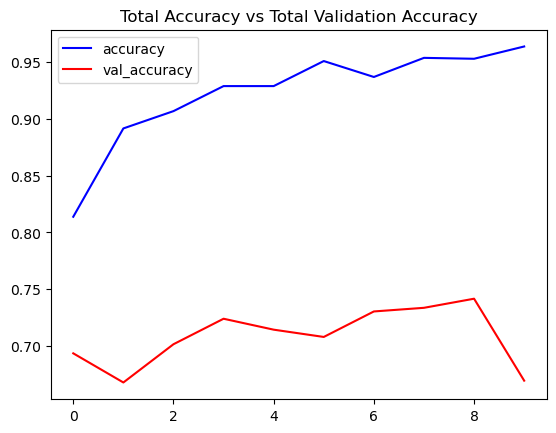

In [19]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [20]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [21]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         1,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,951 (288.87 KB)

 Trainable params: 73,951 (288.87 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [22]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])



In [23]:
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 216s 257ms/step - accuracy: 0.0556 - loss: 3.3688 - val_accuracy: 0.1348 - val_loss: 3.0402
Epoch 2/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 131s 210ms/step - accuracy: 0.1675 - loss: 2.9553 - val_accuracy: 0.2151 - val_loss: 2.7597
Epoch 3/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 131s 210ms/step - accuracy: 0.2155 - loss: 2.7194 - val_accuracy: 0.2119 - val_loss: 2.6630
Epoch 4/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 189s 303ms/step - accuracy: 0.2569 - loss: 2.5062 - val_accuracy: 0.2215 - val_loss: 2.5350
Epoch 5/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 182s 291ms/step - accuracy: 0.2932 - loss: 2.4187 - val_accuracy: 0.2873 - val_loss: 2.3819
Epoch 6/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 189s 304ms/step - accuracy: 0.3210 - loss: 2.2194 - val_accuracy: 0.3355 - val_loss: 2.2531
Epoch 7/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 178s 286ms/step - accuracy: 0.3890 - loss: 2.0272 - val_accuracy: 0.3323 - val_loss: 2.2152
Epoch 8/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 192s 307ms/step - accuracy: 0.4288 -

In [24]:
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 192s 305ms/step - accuracy: 0.9196 - loss: 0.2668 - val_accuracy: 0.8010 - val_loss: 0.8286
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 196s 315ms/step - accuracy: 0.9310 - loss: 0.2415 - val_accuracy: 0.8074 - val_loss: 0.8400
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 178s 285ms/step - accuracy: 0.9229 - loss: 0.2699 - val_accuracy: 0.8234 - val_loss: 0.7990
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 132s 212ms/step - accuracy: 0.9473 - loss: 0.2045 - val_accuracy: 0.7881 - val_loss: 0.9682
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 133s 213ms/step - accuracy: 0.9458 - loss: 0.2106 - val_accuracy: 0.7592 - val_loss: 1.0393
Epoch 6/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 132s 213ms/step - accuracy: 0.9326 - loss: 0.2274 - val_accuracy: 0.8523 - val_loss: 0.7314
Epoch 7/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 135s 217ms/step - accuracy: 0.9580 - loss: 0.1604 - val_accuracy: 0.8427 - val_loss: 0.7049
Epoch 8/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 174s 280ms/step - accuracy: 0.9509 -

In [25]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8364 - loss: 0.7373


In [26]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()
# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = 'LRCN_model1.h5'

# Save the Model.
LRCN_model.save(model_file_name)

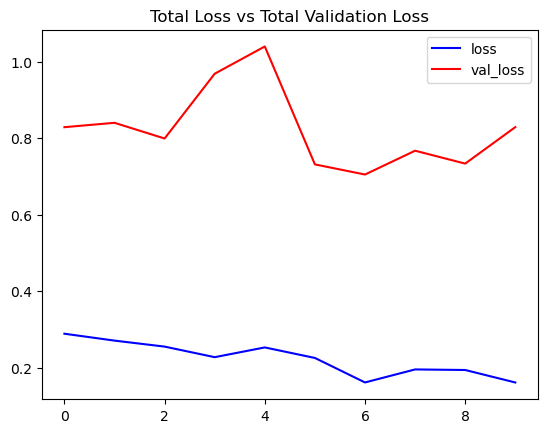

In [27]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

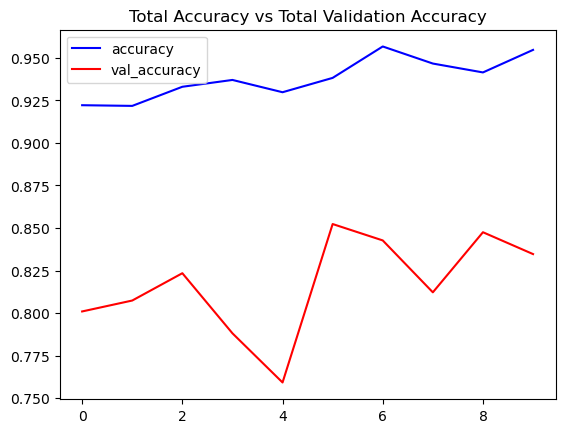

In [28]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [30]:
LRCN_model = tf.keras.models.load_model('LRCN_model1.h5')

# Make predictions on the test data
predictions = LRCN_model.predict(features_test)

# Convert one-hot encoded predictions back to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels back to class labels
true_labels = np.argmax(labels_test, axis=1)

# Initialize dictionaries to store counts of correct and wrong predictions for each label
correct_predictions_count = {}
wrong_predictions_count = {}

# Loop through each label
for label_index, class_name in enumerate(CLASSES_LIST):
    # Find indices where the true label matches the current label
    indices = np.where(true_labels == label_index)[0]
    
    # Count how many predictions for those indices are correct
    correct_count = np.sum(predicted_labels[indices] == true_labels[indices])
    
    # Count how many predictions for those indices are wrong
    wrong_count = len(indices) - correct_count
    
    # Store counts in the dictionaries
    correct_predictions_count[class_name] = correct_count
    wrong_predictions_count[class_name] = wrong_count

# Print the counts of correct and wrong predictions for each label
for class_name in CLASSES_LIST:
    print(f'Label: {class_name}, Correct Predictions: {correct_predictions_count[class_name]}, Wrong Predictions: {wrong_predictions_count[class_name]}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step
Label: BaseballPitch, Correct Predictions: 40, Wrong Predictions: 4
Label: Basketball, Correct Predictions: 23, Wrong Predictions: 10
Label: BenchPress, Correct Predictions: 49, Wrong Predictions: 2
Label: Billiards, Correct Predictions: 35, Wrong Predictions: 1
Label: BreastStroke, Correct Predictions: 28, Wrong Predictions: 3
Label: CleanAndJerk, Correct Predictions: 24, Wrong Predictions: 6
Label: Diving, Correct Predictions: 32, Wrong Predictions: 7
Label: Drumming, Correct Predictions: 30, Wrong Predictions: 5
Label: Fencing, Correct Predictions: 19, Wrong Predictions: 4
Label: GolfSwing, Correct Predictions: 21, Wrong Predictions: 8
Label: HorseRace, Correct Predictions: 27, Wrong Predictions: 5
Label: HulaHoop, Correct Predictions: 20, Wrong Predictions: 14
Label: JumpingJack, Correct Predictions: 34, Wrong Predictions: 4
Label: JumpRope, Correct Predictions: 39, Wrong Predictions: 0
Label: MilitaryParade, Correct Predictions: 23, Wrong 